# Debris removal

This notebook is meant to compute the size threshold separating debris from nuclei using the `tilesegment` package.

Import packages, load segmentation model and define input and output paths

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tilesegment import rotating_calipers, get_outlines_masks_labels, compute_closest_larger_multiple, tif_reader_5D, get_file_names
import numpy as np

# ### LOAD STARDIST MODEL ###
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

from csbdeep.utils import normalize
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
})
mpl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx} \sisetup{detect-all} \usepackage{helvet} \usepackage{sansmath} \sansmath'
mpl.rc('font', size=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('legend', fontsize=18) 

### PATH TO YOU DATA FOLDER AND TO YOUR SAVING FOLDERS ###
path_data='/path/to/data/'
path_save='/path/to/segmentation/results/'
path_figures = '/path/to/figures/folder'

2025-10-24 16:22:36.566219: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 16:22:36.567237: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 16:22:36.588379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 16:22:36.588911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 16:22:37.023000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-10-24 16:22:37.481517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-24 16:22:37.485538: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Load the file names for the two repeats of the negative control and the three repeats of the treated experiment. Also, define the output lists were we will append the quantification results.

In [2]:
### GET FULL FILE NAME AND FILE CODE ###
files = get_file_names(path_data)

files1_neg = [file for file in files if "2i_Nanog_1" in file]
files2_neg = [file for file in files if "2i_Nanog_2" in file]

files1 = [file for file in files if "dox_Nanog_1" in file]
files2 = [file for file in files if "dox_Nanog_2" in file]
files3 = [file for file in files if "dox_Nanog_3" in file]

nanog_neg = []
perk_neg = []
gata6_neg = []

nanog = []
perk = []
gata6 = []

We first segment and quantify the negative control and then the treated case. In the following block of code, for each file we first load the images for each channel. Then, we define tiling information. For more information on how the tiling segmentation works. Finally, we perform the segmentation and use the masks to extract the mean fluorescence in each segmented nuclei. During this process, we use the size threshold to remove debris masks.

In [3]:
for filen in [files1_neg, files2_neg]:
    file_hoechst = [f for f in filen if "ch00" in f][0]
    file_nanog = [f for f in filen if "ch01" in f][0]
    file_perk = [f for f in filen if "ch02" in f][0]
    file_gata6 = [f for f in filen if "ch03" in f][0]

    ### LOAD HYPERSTACKS ###
    IMGS_h, met_h = tif_reader_5D(path_data+file_hoechst)
    IMG_h = np.max(IMGS_h[0, :4, 0].astype("int32"), axis=0)
    IMG_h = np.where(IMG_h <= 255, IMG_h, 255).astype("uint8")

    IMGS_n, met_n = tif_reader_5D(path_data+file_nanog)
    IMG_n = np.max(IMGS_n[0, :4, 0].astype("int32"), axis=0)
    IMG_n = np.where(IMG_n <= 255, IMG_n, 255).astype("uint8")


    IMGS_p, met_p = tif_reader_5D(path_data+file_perk)
    IMG_p = np.max(IMGS_p[0, :4, 0].astype("int32"), axis=0)
    IMG_p = np.where(IMG_p <= 255, IMG_p, 255).astype("uint8")


    IMGS_g, met_g = tif_reader_5D(path_data+file_gata6)
    IMG_g = np.max(IMGS_g[0, :4, 0].astype("int32"), axis=0)
    IMG_g = np.where(IMG_g <= 255, IMG_g, 255).astype("uint8")

    ### TILING ###

    # Tile size
    Ts = 1024

    # Define overlap by running a segmentation test and checking mean cell diameter after removing small objects
    # Total image size
    sh = IMG_h.shape
    D = compute_closest_larger_multiple(max(sh), Ts)

    # indexed to be used for image reconstruction
    ishdiff = D-sh[0]
    top_ishdiff = np.int32(np.ceil(ishdiff/2))
    bot_ishdiff = np.int32(np.floor(ishdiff/2))
    jshdiff = D-sh[1]
    lef_jshdiff = np.int32(np.ceil(jshdiff/2))
    rig_jshdiff = np.int32(np.floor(jshdiff/2))

    # Size with overlap
    O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation

    Tso = Ts + 2*O
    DO = D + 2*O

    # Number of tiles
    n = int(D/Ts)
    N = int(n**2)


    # Create squared and padded image
    IMG_padded = np.zeros((DO,DO))
    IMG_padded[O+top_ishdiff:-O-bot_ishdiff, O+lef_jshdiff:-O-rig_jshdiff] = IMG_h

    labels = np.zeros_like(IMG_padded)
    maxlab=0

    centers = []
    masks = []
    diameters1 = []
    tiles_left = N

    diam_th = 30.30

    for i in range(n):
        idsi= slice((i*Ts),((i+1)*Ts+2*O))
        for j in range(n):
            idsj= slice((j*Ts),((j+1)*Ts+2*O))
            img = IMG_padded[idsi, idsj]
            labs, _ = model.predict_instances(normalize(img))

            # labs, flows, styles = model.eval(img)
            outlines, _masks, _labs = get_outlines_masks_labels(labs) 
            for l, lab in enumerate(_labs):
                outline = outlines[l]
                mask = _masks[l]
                diam = rotating_calipers(outline)
                center = np.mean(mask, axis=0)
                # check if label center falls out of the limits
                mins = O, O
                maxs = Ts+O, Ts+O
                
                if (((center < mins).any() or (center > maxs).any()) or (diam < diam_th)):
                    labs[mask[:,0], mask[:,1]] = 0
                else:
                    offset = np.array([i*Ts-O-top_ishdiff, j*Ts-O-lef_jshdiff])
                    centers.append(center+offset)
                    masks.append(mask+offset)
                    diameters1.append(diam)

            labs += maxlab
            background = np.transpose(np.where(labs == maxlab))
            labs[background[:,0], background[:,1]] = 0
            maxlab = labs.max()
            labels[idsi, idsj] += labs
            tiles_left -=1
            print("tiles left =", tiles_left)

    ### SEGMENTATION COMPLETED   ###

    ### COLOCALIZATION AND DENSITY PLOTS ###

    for mask in masks:
        mask[mask < 0] = 0
        mask[:,0][mask[:,0]>=IMG_p.shape[0]] = IMG_p.shape[0]-1
        mask[:,1][mask[:,1]>=IMG_p.shape[1]] = IMG_p.shape[1]-1

        nanog_neg.append(np.mean(IMG_n[mask[:,0], mask[:,1]]))
        perk_neg.append(np.mean(IMG_p[mask[:,0], mask[:,1]]))
        gata6_neg.append(np.mean(IMG_g[mask[:,0], mask[:,1]]))
        
    
for filen in [files1, files2, files3]:
    file_hoechst = [f for f in filen if "ch00" in f][0]
    file_nanog = [f for f in filen if "ch01" in f][0]
    file_perk = [f for f in filen if "ch02" in f][0]
    file_gata6 = [f for f in filen if "ch03" in f][0]

    ### LOAD HYPERSTACKS ###
    IMGS_h, met_h = tif_reader_5D(path_data+file_hoechst)
    IMG_h = np.max(IMGS_h[0, :4, 0].astype("int32"), axis=0)
    IMG_h = np.where(IMG_h <= 255, IMG_h, 255).astype("uint8")

    IMGS_n, met_n = tif_reader_5D(path_data+file_nanog)
    IMG_n = np.max(IMGS_n[0, :4, 0].astype("int32"), axis=0)
    IMG_n = np.where(IMG_n <= 255, IMG_n, 255).astype("uint8")

    IMGS_p, met_p = tif_reader_5D(path_data+file_perk)
    IMG_p = np.max(IMGS_p[0, :4, 0].astype("int32"), axis=0)
    IMG_p = np.where(IMG_p <= 255, IMG_p, 255).astype("uint8")

    IMGS_g, met_g = tif_reader_5D(path_data+file_gata6)
    IMG_g = np.max(IMGS_g[0, :4, 0].astype("int32"), axis=0)
    IMG_g = np.where(IMG_g <= 255, IMG_g, 255).astype("uint8")

    ### TILING ###

    # Tile size
    Ts = 1024

    # Define overlap by running a segmentation test and checking mean cell diameter after removing small objects
    # Total image size
    sh = IMG_h.shape
    D = compute_closest_larger_multiple(max(sh), Ts)

    # indexed to be used for image reconstruction
    ishdiff = D-sh[0]
    top_ishdiff = np.int32(np.ceil(ishdiff/2))
    bot_ishdiff = np.int32(np.floor(ishdiff/2))
    jshdiff = D-sh[1]
    lef_jshdiff = np.int32(np.ceil(jshdiff/2))
    rig_jshdiff = np.int32(np.floor(jshdiff/2))

    # Size with overlap
    O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation

    Tso = Ts + 2*O
    DO = D + 2*O

    # Number of tiles
    n = int(D/Ts)
    N = int(n**2)


    # Create squared and padded image
    IMG_padded = np.zeros((DO,DO))
    IMG_padded[O+top_ishdiff:-O-bot_ishdiff, O+lef_jshdiff:-O-rig_jshdiff] = IMG_h

    labels = np.zeros_like(IMG_padded)
    maxlab=0

    centers = []
    masks = []
    diameters1 = []
    tiles_left = N

    diam_th = 30.30

    for i in range(n):
        idsi= slice((i*Ts),((i+1)*Ts+2*O))
        for j in range(n):
            idsj= slice((j*Ts),((j+1)*Ts+2*O))
            img = IMG_padded[idsi, idsj]
            labs, _ = model.predict_instances(normalize(img))
            outlines, _masks, _labs = get_outlines_masks_labels(labs) 
            for l, lab in enumerate(_labs):
                outline = outlines[l]
                mask = _masks[l]
                diam = rotating_calipers(outline)
                center = np.mean(mask, axis=0)
                
                # check if label center falls out of the limits
                mins = O, O
                maxs = Ts+O, Ts+O
                
                if (((center < mins).any() or (center > maxs).any()) or (diam < diam_th)):
                    labs[mask[:,0], mask[:,1]] = 0
                else:
                    offset = np.array([i*Ts-O-top_ishdiff, j*Ts-O-lef_jshdiff])
                    centers.append(center+offset)
                    masks.append(mask+offset)
                    diameters1.append(diam)

            labs += maxlab
            background = np.transpose(np.where(labs == maxlab))
            labs[background[:,0], background[:,1]] = 0
            maxlab = labs.max()
            labels[idsi, idsj] += labs
            tiles_left -=1
            print("tiles left =", tiles_left)

    ### SEGMENTATION COMPLETED   ###
    for mask in masks:
        mask[mask < 0] = 0
        mask[:,0][mask[:,0]>=IMG_p.shape[0]] = IMG_p.shape[0]-1
        mask[:,1][mask[:,1]>=IMG_p.shape[1]] = IMG_p.shape[1]-1

        nanog.append(np.mean(IMG_n[mask[:,0], mask[:,1]]))
        perk.append(np.mean(IMG_p[mask[:,0], mask[:,1]]))
        gata6.append(np.mean(IMG_g[mask[:,0], mask[:,1]]))

         raw array with shape (10, 2787, 2785)
         returning array with shape (1, 10, 1, 2787, 2785)
         raw array with shape (10, 2787, 2785)
         returning array with shape (1, 10, 1, 2787, 2785)
         raw array with shape (10, 2787, 2785)
         returning array with shape (1, 10, 1, 2787, 2785)
         raw array with shape (10, 2787, 2785)
         returning array with shape (1, 10, 1, 2787, 2785)
1/1 [==============================] - 0s 298ms/step
tiles left = 8
1/1 [==============================] - 0s 163ms/step
tiles left = 7
1/1 [==============================] - 0s 165ms/step
tiles left = 6
1/1 [==============================] - 0s 163ms/step
tiles left = 5
1/1 [==============================] - 0s 166ms/step
tiles left = 4
1/1 [==============================] - 0s 159ms/step
tiles left = 3
1/1 [==============================] - 0s 161ms/step
tiles left = 2
1/1 [==============================] - 0s 160ms/step
tiles left = 1
1/1 [===========================

We perform k-means clustering of the NANOG and GATA6 quantifications to classify cells into PrE and Epi.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Instantiate KMeans with the number of clusters

X = np.transpose(np.asarray([np.log(nanog), np.log(gata6)]))

kmeans = KMeans(n_clusters=2)

# Fit the KMeans model to the data
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

nanog_pre = []
nanog_epi = []
nanog_dp = []

gata6_pre = []
gata6_epi = []
gata6_dp  = []

perk_pre = []
perk_epi = []
perk_dp  = []

colors = []
fates = np.argsort(cluster_centers[:,0])

for i, lab in enumerate(labels):
    if lab==fates[0]:
        nanog_pre.append(nanog[i])
        gata6_pre.append(gata6[i])
        perk_pre.append(perk[i])
        colors.append("magenta")
    
    # Uncomment this bit if working with three clusters
    
    # elif lab==fates[1]:
    #     nanog_dp.append(nanog[i])
    #     gata6_dp.append(gata6[i])
    #     perk_dp.append(perk[i])
    #     colors.append("cyan")
    # elif lab==fates[2]:
    elif lab==fates[1]:
        nanog_epi.append(nanog[i])
        gata6_epi.append(gata6[i])
        perk_epi.append(perk[i])
        colors.append([0,0.8,0])

Finally, we plot and save the results.

cbook.py (1072): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
2916683495.py (60): The figure layout has changed to tight


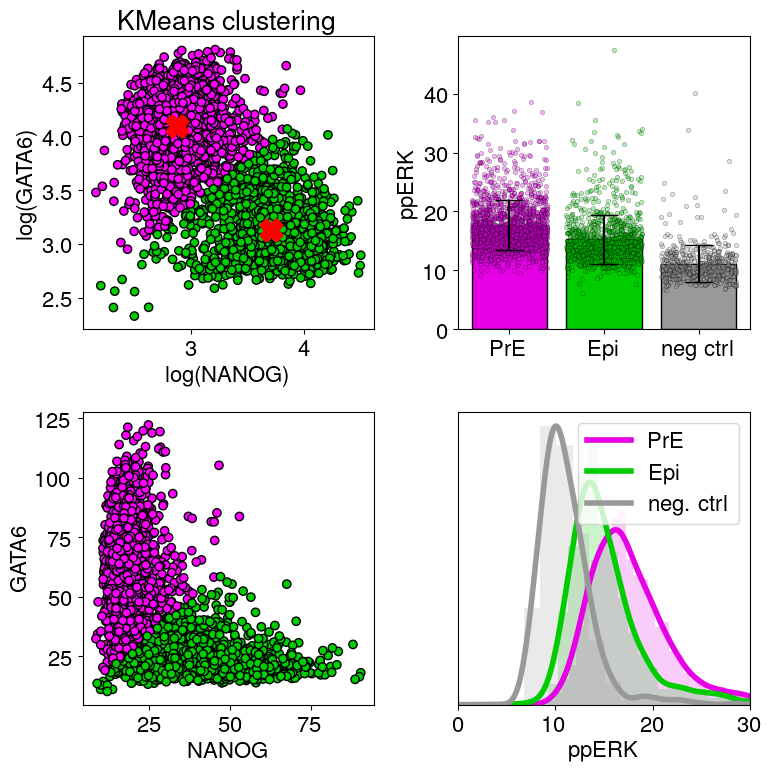

In [5]:

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
})
mpl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx} \sisetup{detect-all} \usepackage{helvet} \usepackage{sansmath} \sansmath'
mpl.rc('font', size=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 

fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(8,8))

ax[0,0].scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')
ax[0,0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=200, linewidths=3, color='red', label='Cluster Centers')
ax[0,0].set_xlabel('log(NANOG)')
ax[0,0].set_ylabel('log(GATA6)')
ax[0,0].set_title('KMeans clustering')

ax[1,0].scatter(nanog, gata6, c=colors, edgecolors='k')
ax[1,0].set_xlabel('NANOG')
ax[1,0].set_ylabel('GATA6')

w = 0.8 
ax[0,1].bar(
    [1,2,3],
    height=[np.mean(perk_pre), np.mean(perk_epi), np.mean(perk_neg)],
    yerr = [np.std(perk_pre), np.std(perk_epi), np.std(perk_neg)],
    capsize=10,
    width=w,
    tick_label=["PrE", "Epi", "neg ctrl"],
    color=[[0.9,0,0.9], [0,0.8,0], [0.6,0.6, 0.6]],
    edgecolor="black"
)
ax[0,1].set_ylabel("ppERK")
ax[0,1].scatter(1 + np.random.random(len(perk_pre)) * w - w / 2, perk_pre, color=[0.9,0,0.9,0.3], s=10, edgecolor=[0.0,0,0.0,0.3], linewidth=0.5)
ax[0,1].scatter(2 + np.random.random(len(perk_epi)) * w - w / 2, perk_epi, color=[0,0.8,0,0.3], s=10, edgecolor=[0.0,0,0.0,0.3], linewidth=0.5)
ax[0,1].scatter(3 + np.random.random(len(perk_neg)) * w - w / 2, perk_neg, color=[0.6,0.6, 0.6,0.3], s=10, edgecolor=[0.0,0,0.0,0.3], linewidth=0.5)

from scipy import stats
kde = stats.gaussian_kde(perk_pre)
xx = np.linspace(0, 40, 1000)
ax[1,1].plot(xx, kde(xx), color=[0.9,0,0.9], lw=4, label="PrE")
ax[1,1].hist(perk_pre, color=[0.9,0,0.9,0.2], bins=40, density=True)

kde = stats.gaussian_kde(perk_epi)
xx = np.linspace(0, 40, 1000)
ax[1,1].plot(xx, kde(xx), color=[0,0.8,0], lw=4, label="Epi")
ax[1,1].hist(perk_epi, color=[0,0.8,0,0.2], bins=40, density=True)

kde = stats.gaussian_kde(perk_neg)
xx = np.linspace(0, 40, 1000)
ax[1,1].plot(xx, kde(xx), color=[0.6,0.6,0.6], lw=4, label="neg. ctrl")
ax[1,1].hist(perk_neg, color=[0.6,0.6,0.6,0.2], bins=20, density=True)

ax[1,1].legend()
ax[1,1].set_xlim(0,30)
ax[1,1].set_yticks([])
ax[1,1].set_xlabel("ppERK")
plt.tight_layout()
plt.savefig(path_figures+"ppERK_quant.svg")
plt.show()